<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 
</p>    
<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.
<p>
Le modèle étudié se base sur les données fournies par le site de StackOverFlow.
</p>
<p>
Ce notebook présente un système de suggestion de TAGS basé sur des méthodes statistiques.
</p>
<p>
Le traitement des données réalisé dans le notebook 'P6_DataAnalysis' sont utilisées pour alimenter les modèles.
</p>



In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import p6_util
import p6_util_plot

dict_stat_result = dict()

import p5_util

import pandas as pd
def p6_load_dataset_benchmark() :
    file_name="./data/StackOverFlowTags.csv"
    df_sof_tags=pd.read_csv(file_name)
    print(df_sof_tags.shape)
    list_sof_tag = df_sof_tags.TagName.tolist( )

    file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
    df_sof_test=pd.read_csv(file_name)

    df_sof_test['Body']=df_sof_test['Body']+df_sof_test['Title']

    file_name='./data/ser_sof_train.dump'
    ser_sof_train = p5_util.object_load(file_name)
    print(ser_sof_train.shape)
    return ser_sof_train, df_sof_test, list_sof_tag

# <font color='blus'>5. Statistical TAGs assignement methods</font>

**Loading cleaned Posts train dataset**

In [3]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)
print(ser_sof_train.shape)

p5_util.object_load : fileName= ./data/ser_sof_train.dump
(24604,)


**Loading test dataset**

In [4]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

**POST is created from Body and Title columns**

In [5]:
df_sof_test['Body']=df_sof_test['Body']+df_sof_test['Title']

**Loading target : list of TAGs from SOF**

In [6]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist( )

(50000, 2)


## <font color='blus'>5.1 Body+Title : Features creation from Bag of Words</font>

* Dataset is tokenized
* Corpus is represented as a matrix
* Matrix values are tokens frequencies (TF)

**BOW Vectorization with (1-GRAM terms)**

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import p5_util

embeding_mode='bow'

ngram=1
vectorizer_bow = CountVectorizer(min_df=0.001, max_df=.1, ngram_range=(ngram, ngram))
csr_matrix_bow = vectorizer_bow.fit_transform(ser_sof_train)

print(csr_matrix_bow.shape)

file_name='./data/csr_matrix_bow.dump'
p5_util.object_dump(csr_matrix_bow, file_name)

(24604, 2492)


In [2]:
import p5_util
file_name='./data/vectorizer_bow.dump'
vectorizer_bow = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/vectorizer_bow.dump


In [3]:
vectorizer_bow

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=None, min_df=0.001,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

The 24604 posts are expanded over 2463 features.

### <font color='blus'>5.1.1 Statistical method evaluation based on BOW</font>

For each raw from CSR matrix, the N greater values are extracted.

Matching Key words from columns are chosen from vacabulary.

Those keywords are assigned as TAGs (suggested tags).


In [10]:
import p6_util

nb_test = int(len(df_sof_test)/50)

modulo=int(nb_test/10)
nb_test, modulo

dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_bow, csr_matrix_bow,p_tag_ratio=None, embeding_mode='bow' )

import p5_util
file_name='./data/dict_match_result_bow_stat.dump'
p5_util.object_dump(dict_match_result, file_name)


Test mode bow covering 327 documents

Processed documents : 32/327
Processed documents : 64/327
Processed documents : 96/327
Processed documents : 128/327
Processed documents : 160/327
Processed documents : 192/327
Processed documents : 224/327
Processed documents : 256/327
Processed documents : 288/327
Processed documents : 320/327


In [11]:
import p5_util
file_name='./data/dict_match_result_bow_stat.dump'
dict_match_result = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_match_result_bow_stat.dump


In [12]:
import p6_util
arr_similarity_result, arr_matching_result , stat_mean_accuracy_score = p6_util.p6_stat_compute_result(dict_match_result)


*** Matching results : 0.09 %


In [13]:
dict_stat_result['BOW'] = stat_mean_accuracy_score

/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


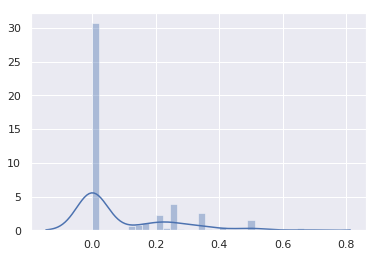

In [14]:
import seaborn as sns, numpy as np
sns.set()

ax = sns.distplot(arr_matching_result, bins=30)

## <font color='blus'>5.2 TF-IDF  with ngram=(1,1)</font>

* Terms having a frequency occurence greater then ``p_max_df`` threshold are ignored
* Terms having a frequency occurence less then ``p_min_df`` threshold are ignored

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import p5_util

# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.001

# When building vacabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 1.

ngram1=1
ngram2=1
vectorizer_tfidf_ngram1=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram1 = vectorizer_tfidf_ngram1.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram1.shape)

file_name='./data/dict_match_result_tfidf_ngram1_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

print("MIN DF= "+str(p_min_df)+"  MAX DF = "+str(p_max_df))

(24604, 2512)
MIN DF= 0.001  MAX DF = 1.0


In [16]:
import p5_util
import p6_util

nb_test = int(len(df_sof_test)/10)

modulo=int(nb_test/10)
print("Nb tests= {} Modulo={}".format(nb_test, modulo))

dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram1, csr_matrix_tfidf_ngram1,p_tag_ratio=None, embeding_mode='tfidf' )

file_name='./data/dict_match_result_tfidf_ngram1_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

Nb tests= 1635 Modulo=163

Test mode tfidf covering 1635 documents

Processed documents : 163/1635
Processed documents : 326/1635
Processed documents : 489/1635
Processed documents : 652/1635
Processed documents : 815/1635
Processed documents : 978/1635
Processed documents : 1141/1635
Processed documents : 1304/1635
Processed documents : 1467/1635
Processed documents : 1630/1635


In [17]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1_stat.dump'
dict_match_result = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat.dump


In [18]:
import p6_util
arr_similarity_result, arr_matching_result, stat_mean_accuracy_score = p6_util.p6_stat_compute_result(dict_match_result)

dict_stat_result["TFIDF(1,1)"] = stat_mean_accuracy_score
dict_stat_result


*** Matching results : 0.11 %


{'BOW': 0.08886704528906363, 'TFIDF(1,1)': 0.10965813663061368}

/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


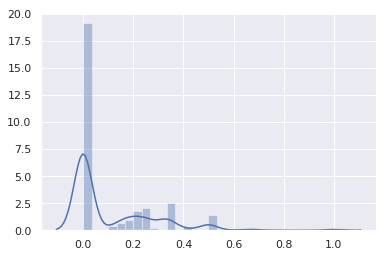

In [19]:
import seaborn as sns, numpy as np
sns.set()
np.random.seed(0)
ax = sns.distplot(arr_matching_result, bins=30)

## <font color='blus'>5.3 TF-IDF  with ngram=(2,2)</font>

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

ngram1=2
ngram2=2
vectorizer_tfidf_ngram2=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram2 = vectorizer_tfidf_ngram2.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram2.shape)

(24604, 1386)


In [21]:
import p5_util
import p6_util

nb_test = int(len(df_sof_test)/10)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))

dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram2, csr_matrix_tfidf_ngram2,p_tag_ratio=None, embeding_mode='tfidf' )

file_name='./data/dict_match_result_tfidf_ngram2_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

Nb tests= 1635 Module=163

Test mode tfidf covering 1635 documents

Processed documents : 163/1635
Processed documents : 326/1635
Processed documents : 489/1635
Processed documents : 652/1635
Processed documents : 815/1635
Processed documents : 978/1635
Processed documents : 1141/1635
Processed documents : 1304/1635
Processed documents : 1467/1635
Processed documents : 1630/1635


In [22]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram2_stat.dump'
dict_match_result = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram2_stat.dump


In [23]:
import p6_util
arr_similarity_result, arr_matching_result, stat_mean_accuracy_score = p6_util.p6_stat_compute_result(dict_match_result)

dict_stat_result["TFIDF(2,2)"] = stat_mean_accuracy_score
dict_stat_result


*** Matching results : 0.00 %


{'BOW': 0.08886704528906363,
 'TFIDF(1,1)': 0.10965813663061368,
 'TFIDF(2,2)': 0.0}

/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/bangui/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/bangui/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/bangui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

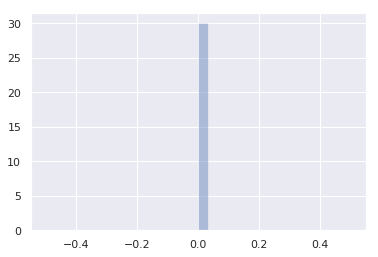

In [24]:
import seaborn as sns, numpy as np
sns.set()
np.random.seed(0)
#x = np.random.randn(100)
ax = sns.distplot(arr_matching_result, bins=30)

## <font color='blus'>5.4. TF-IDF  with ngram=(1,2)</font>

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

nb_test = int(len(df_sof_test)/50)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))


ngram1=1
ngram2=2
vectorizer_tfidf_ngram1_2=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram1_2 = vectorizer_tfidf_ngram1_2.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram1_2.shape)

Nb tests= 327 Module=32
(24604, 3898)


In [26]:
import p5_util
import p6_util

dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram1_2, csr_matrix_tfidf_ngram1_2,p_tag_ratio=None, embeding_mode='tfidf' )

file_name='./data/dict_match_result_tfidf_ngram1_2_stat.dump'
p5_util.object_dump(dict_match_result, file_name)


Test mode tfidf covering 327 documents

Processed documents : 32/327
Processed documents : 64/327
Processed documents : 96/327
Processed documents : 128/327
Processed documents : 160/327
Processed documents : 192/327
Processed documents : 224/327
Processed documents : 256/327
Processed documents : 288/327
Processed documents : 320/327


In [27]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1_2_stat.dump'
dict_match_result = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_2_stat.dump


In [28]:
import p6_util
arr_similarity_result, arr_matching_result, stat_mean_accuracy_score = p6_util.p6_stat_compute_result(dict_match_result)

dict_stat_result["TFIDF(1,2)"] = stat_mean_accuracy_score
dict_stat_result


*** Matching results : 0.08 %


{'BOW': 0.08886704528906363,
 'TFIDF(1,1)': 0.10965813663061368,
 'TFIDF(2,2)': 0.0,
 'TFIDF(1,2)': 0.08272182285943754}

/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


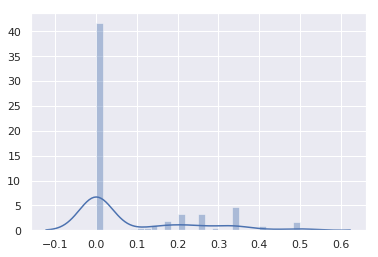

In [29]:
import seaborn as sns, numpy as np
sns.set()
#x = np.random.randn(100)
ax = sns.distplot(arr_matching_result, bins=30)

## <font color='blus'> 5.5. Optimized TFIDF Vectorization</font>

**Loading target : list of TAGs from SOF**

In [30]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist( )

(50000, 2)


**Loading test dataset**

In [31]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)
df_sof_test.shape

(16359, 5)

In [32]:
df_sof_test['Body']=df_sof_test['Body']+df_sof_test['Title']

**Loading cleaned train dataset of Posts**

In [33]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)
print(ser_sof_train.shape)

p5_util.object_load : fileName= ./data/ser_sof_train.dump
(24604,)


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
import p5_util

# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.0006

# When building vocabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 1.

ngram1=1
ngram2=1
vectorizer_tfidf_ngram1_b=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram1_b = vectorizer_tfidf_ngram1_b.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram1_b.shape)

print("MIN DF= "+str(p_min_df)+"  MAX DF = "+str(p_max_df))

file_name='./data/csr_matrix_tfidf_ngram1_b.dump'
p5_util.object_dump(csr_matrix_tfidf_ngram1_b,file_name)
print(csr_matrix_tfidf_ngram1_b.shape)
 

file_name='./data/vectorizer_tfidf_ngram1_b.dump'
p5_util.object_dump(vectorizer_tfidf_ngram1_b,file_name)

(24604, 3388)
MIN DF= 0.0006  MAX DF = 1.0
(24604, 3388)


In [35]:
import p5_util
file_name='./data/csr_matrix_tfidf_ngram1_b.dump'
csr_matrix_tfidf_ngram1_b = p5_util.object_load(file_name)
print(csr_matrix_tfidf_ngram1_b.shape)
 
file_name='./data/vectorizer_tfidf_ngram1_b.dump'
vectorizer_tfidf_ngram1_b = p5_util.object_load(file_name)



p5_util.object_load : fileName= ./data/csr_matrix_tfidf_ngram1_b.dump
(24604, 3388)
p5_util.object_load : fileName= ./data/vectorizer_tfidf_ngram1_b.dump


In [36]:
import p6_util

nb_test = int(len(df_sof_test)/50)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))

dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram1_b, csr_matrix_tfidf_ngram1_b,p_tag_ratio=None, embeding_mode='tfidf' )

import p5_util
file_name='./data/dict_match_result_tfidf_ngram1plus_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

Nb tests= 327 Module=32

Test mode tfidf covering 327 documents

Processed documents : 32/327
Processed documents : 64/327
Processed documents : 96/327
Processed documents : 128/327
Processed documents : 160/327
Processed documents : 192/327
Processed documents : 224/327
Processed documents : 256/327
Processed documents : 288/327
Processed documents : 320/327


In [37]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1plus_stat.dump'
dict_match_result = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1plus_stat.dump


In [38]:
import p6_util
arr_similarity_result, arr_matching_result, stat_mean_accuracy_score = p6_util.p6_stat_compute_result(dict_match_result)

dict_stat_result["TFIDF(1,1) Plus"] = stat_mean_accuracy_score


*** Matching results : 0.10 %


/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


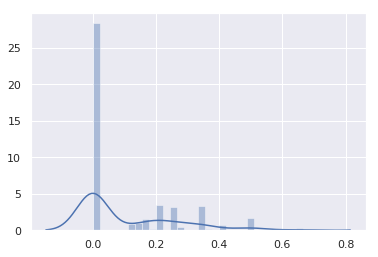

In [39]:
import seaborn as sns, numpy as np
sns.set()
np.random.seed(0)
ax = sns.distplot(arr_matching_result, bins=30)

In [40]:
import pandas as pd
df_result = pd.DataFrame.from_dict( dict_stat_result, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'Model',0:'Score'}, inplace=True)
df_result

,Model,Score
0,BOW,0.088867
1,"TFIDF(1,1)",0.109658
2,"TFIDF(2,2)",0.000000
3,"TFIDF(1,2)",0.082722
4,"TFIDF(1,1) Plus",0.102871


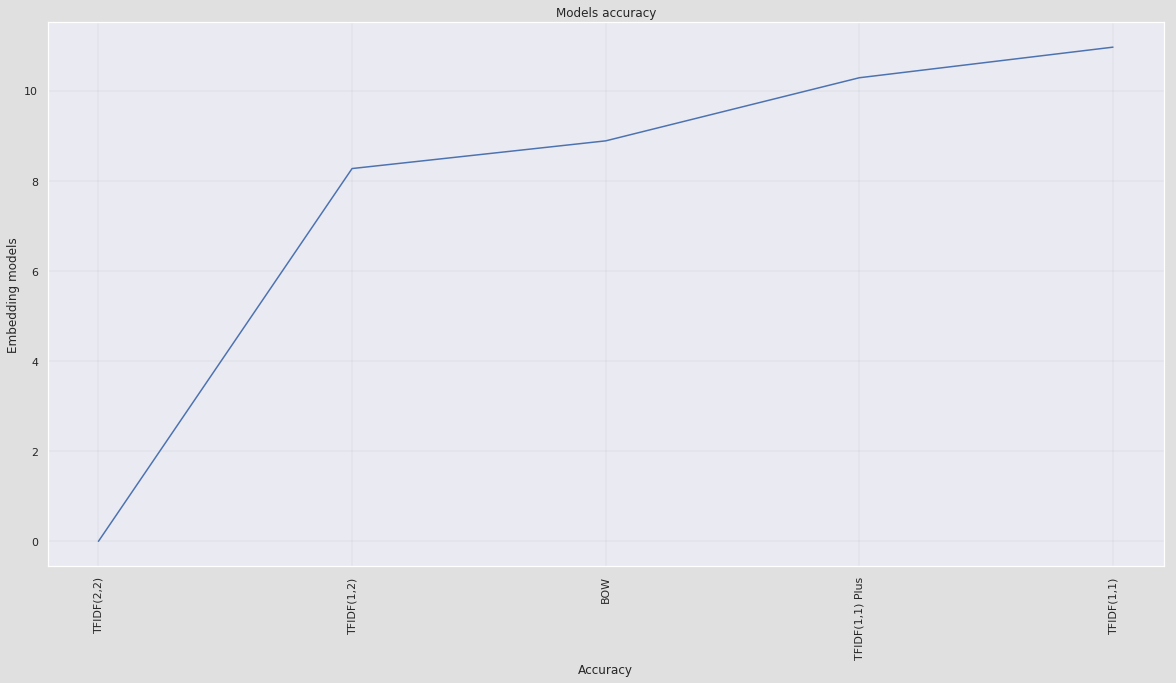

In [41]:
import p6_util_plot
title = "Models accuracy"
p6_util_plot.ser_item_occurency_plot(df_result.Model, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=False, p_y_title='Embedding models')

## <font color='blus'> 5.6. Searcn for best TFIDF (1,1) Vectorization model</font>

**Loading all required dataset for benchmark**

In [11]:
ser_sof_train, df_sof_test, list_sof_tag = p6_load_dataset_benchmark()

(50000, 2)
p5_util.object_load : fileName= ./data/ser_sof_train.dump
(24604,)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import p5_util

dict_stat_result_1_1 = dict()

# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df_list = [0., 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4]
# When building vocabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 1.

In [15]:
ngram1=1
ngram2=1

dict_vectorizer_tfidf_ngram1 = dict()
dict_csr_matrix_tfidf_ngram1 = dict()
for  p_min_df in p_min_df_list :
    
    dict_vectorizer_tfidf_ngram1[p_min_df] \
    = TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

    dict_csr_matrix_tfidf_ngram1[p_min_df] = dict_vectorizer_tfidf_ngram1[p_min_df].fit_transform(ser_sof_train)

    print("MIN DF= "+str(p_min_df)+"  MAX DF = "+str(p_max_df))

    file_name='./data/csr_matrix_tfidf_ngram1_'+str(p_min_df)+'_.dump'
    p5_util.object_dump(dict_csr_matrix_tfidf_ngram1[p_min_df],file_name)
    print(dict_csr_matrix_tfidf_ngram1[p_min_df].shape)
 

    file_name='./data/vectorizer_tfidf_ngram1_'+str(p_min_df)+'_.dump'
    p5_util.object_dump(dict_vectorizer_tfidf_ngram1[p_min_df],file_name)
    print()

MIN DF= 0.0  MAX DF = 1.0
(24604, 33372)

MIN DF= 0.0001  MAX DF = 1.0
(24604, 9037)

MIN DF= 0.0002  MAX DF = 1.0
(24604, 6448)

MIN DF= 0.0003  MAX DF = 1.0
(24604, 4850)

MIN DF= 0.0004  MAX DF = 1.0
(24604, 4271)

MIN DF= 0.0005  MAX DF = 1.0
(24604, 3702)

MIN DF= 0.0006  MAX DF = 1.0
(24604, 3388)

MIN DF= 0.0007  MAX DF = 1.0
(24604, 3047)



In [16]:
import p5_util
import p6_util

nb_test = int(len(df_sof_test)/10)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))
dict_dict_match_result = dict()
for  p_min_df in p_min_df_list :
    vectorizer_tfidf_ngram1 = dict_vectorizer_tfidf_ngram1[p_min_df]
    csr_matrix_tfidf_ngram1 = dict_csr_matrix_tfidf_ngram1[p_min_df]
    dict_dict_match_result[p_min_df] \
    = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
        , vectorizer_tfidf_ngram1, csr_matrix_tfidf_ngram1,p_tag_ratio=None, embeding_mode='tfidf' )

    file_name='./data/dict_match_result_tfidf_ngram1_stat_'+str(p_min_df)+'_.dump'
    p5_util.object_dump(dict_dict_match_result[p_min_df], file_name)

Nb tests= 1635 Module=163

Test mode tfidf covering 1635 documents

Processed documents : 163/1635
Processed documents : 326/1635
Processed documents : 489/1635
Processed documents : 652/1635
Processed documents : 815/1635
Processed documents : 978/1635
Processed documents : 1141/1635
Processed documents : 1304/1635
Processed documents : 1467/1635
Processed documents : 1630/1635

Test mode tfidf covering 1635 documents

Processed documents : 163/1635
Processed documents : 326/1635
Processed documents : 489/1635
Processed documents : 652/1635
Processed documents : 815/1635
Processed documents : 978/1635
Processed documents : 1141/1635
Processed documents : 1304/1635
Processed documents : 1467/1635
Processed documents : 1630/1635

Test mode tfidf covering 1635 documents

Processed documents : 163/1635
Processed documents : 326/1635
Processed documents : 489/1635
Processed documents : 652/1635
Processed documents : 815/1635
Processed documents : 978/1635
Processed documents : 1141/1635
Pr

**Loading dictionary of benchmark results**

In [17]:
import p5_util
dict_dict_match_result = dict()
for  p_min_df in p_min_df_list :
    file_name='./data/dict_match_result_tfidf_ngram1_stat_'+str(p_min_df)+'_.dump'
    dict_dict_match_result[p_min_df] = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0_.dump
p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0001_.dump
p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0002_.dump
p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0003_.dump
p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0004_.dump
p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0005_.dump
p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0006_.dump
p5_util.object_load : fileName= ./data/dict_match_result_tfidf_ngram1_stat_0.0007_.dump


In [18]:
import p6_util
dict_stat_result_all = dict()
for  p_min_df in p_min_df_list :

    arr_similarity_result, arr_matching_result, stat_mean_accuracy_score \
    = p6_util.p6_stat_compute_result(dict_dict_match_result[p_min_df])

    dict_stat_result_all[p_min_df] = stat_mean_accuracy_score



*** Matching results : 0.11 %

*** Matching results : 0.12 %

*** Matching results : 0.12 %

*** Matching results : 0.12 %

*** Matching results : 0.11 %

*** Matching results : 0.12 %

*** Matching results : 0.12 %

*** Matching results : 0.11 %


In [21]:
import pandas as pd
df_result = pd.DataFrame.from_dict( dict_stat_result_all, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'P_MIN',0:'Score'}, inplace=True)
df_result

,P_MIN,Score
0,0.0000,0.112134
1,0.0001,0.116002
2,0.0002,0.117521
3,0.0003,0.117207
4,0.0004,0.114405
5,0.0005,0.116280
6,0.0006,0.115967
7,0.0007,0.113995


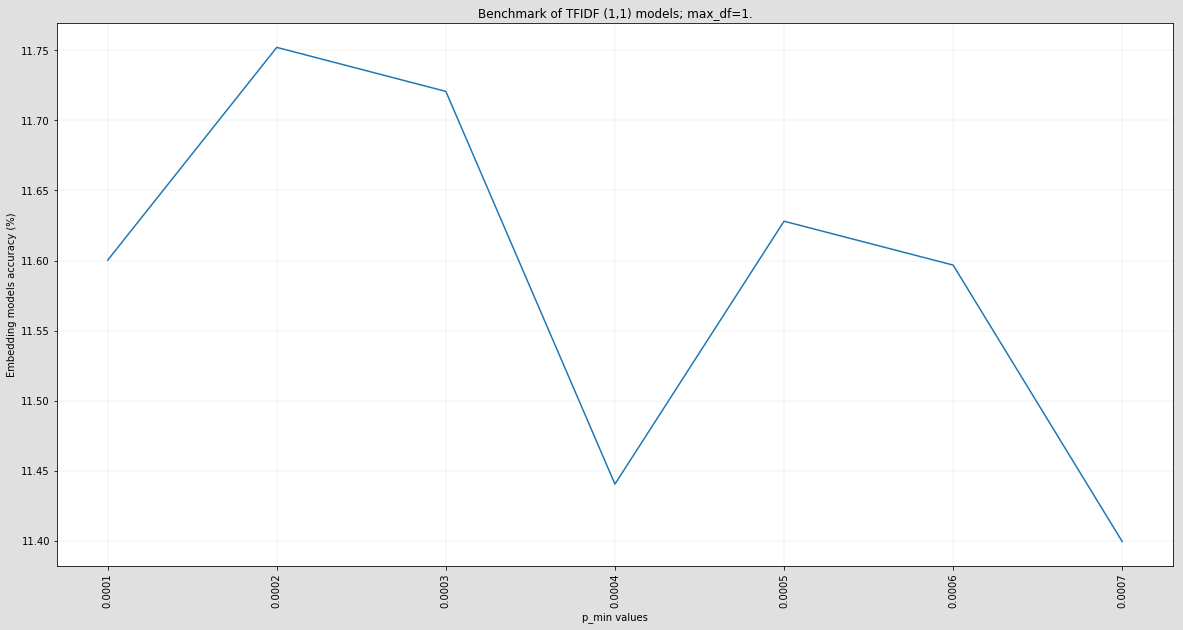

In [26]:
import p6_util_plot
title = "Benchmark of TFIDF (1,1) models; max_df=1."
p6_util_plot.ser_item_occurency_plot(df_result.P_MIN, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=None, p_x_title='p_min values', p_y_title='Embedding models accuracy (%)')

**Fixing optimized p_min_df, searching for best p_amx_df**

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import p5_util

dict_stat_result_1_1 = dict()

# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.0002
# When building vocabulary, terms with frequency document> p_max_df are ignored.
p_max_df_list = [0.1, 2e-1, 3e-1, 4e-1, 5e-1,6e-1, 7e-1, 8e-1, 9e-1, 1.]
p_max_df_list = [1e-2, 2e-2, 3e-2, 4e-2, 5e-2,6e-2, 7e-2, 8e-2, 9e-2, 10e-2]

#p_max_df_list = [1.,]

ngram1=1
ngram2=1
dict_vectorizer_tfidf_ngram1 = dict()
dict_csr_matrix_tfidf_ngram1 = dict()
for  p_max_df in p_max_df_list :
    try :
        dict_vectorizer_tfidf_ngram1[p_max_df] = TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))
    except :
        print("\n*** ERROR for (min,max)= "+str(p_min_df, p_max_df))
        continue
    dict_csr_matrix_tfidf_ngram1[p_max_df] = dict_vectorizer_tfidf_ngram1[p_max_df].fit_transform(ser_sof_train)

    print("MIN DF= "+str(p_min_df)+"  MAX DF = "+str(p_max_df))

    file_name='./data/csr_matrix_tfidf_ngram1_'+str(p_max_df)+'_.dump'
    #p5_util.object_dump(dict_csr_matrix_tfidf_ngram1[p_max_df],file_name)
    print(dict_csr_matrix_tfidf_ngram1[p_max_df].shape)
 

    file_name='./data/vectorizer_tfidf_ngram1_'+str(p_max_df)+'_.dump'
    #p5_util.object_dump(dict_vectorizer_tfidf_ngram1[p_max_df],file_name)
    print()

MIN DF= 0.0002  MAX DF = 0.01
(24604, 5980)

MIN DF= 0.0002  MAX DF = 0.02
(24604, 6232)

MIN DF= 0.0002  MAX DF = 0.03
(24604, 6325)

MIN DF= 0.0002  MAX DF = 0.04
(24604, 6367)

MIN DF= 0.0002  MAX DF = 0.05
(24604, 6389)

MIN DF= 0.0002  MAX DF = 0.06
(24604, 6405)

MIN DF= 0.0002  MAX DF = 0.07
(24604, 6415)

MIN DF= 0.0002  MAX DF = 0.08
(24604, 6422)

MIN DF= 0.0002  MAX DF = 0.09
(24604, 6425)

MIN DF= 0.0002  MAX DF = 0.1
(24604, 6428)



In [31]:
import p5_util
import p6_util

nb_test = int(len(df_sof_test)/50)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))
dict_dict_match_result = dict()
for  p_max_df in p_max_df_list  :
    vectorizer_tfidf_ngram1 = dict_vectorizer_tfidf_ngram1[p_max_df]
    csr_matrix_tfidf_ngram1 = dict_csr_matrix_tfidf_ngram1[p_max_df]
    dict_dict_match_result[p_max_df] \
    = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
        , vectorizer_tfidf_ngram1, csr_matrix_tfidf_ngram1,p_tag_ratio=None, embeding_mode='tfidf' )

    #file_name='./data/dict_match_result_tfidf_ngram1_stat_'+str(p_min_df)+'_.dump'
    #p5_util.object_dump(dict_dict_match_result[p_max_df], file_name)

import p6_util
dict_stat_result_all = dict()
for  p_max_df in p_max_df_list  :
    print("max_df= "+str(p_max_df))
    arr_similarity_result, arr_matching_result, stat_mean_accuracy_score \
    = p6_util.p6_stat_compute_result(dict_dict_match_result[p_max_df])

    dict_stat_result_all[p_max_df] = stat_mean_accuracy_score


import pandas as pd
df_result = pd.DataFrame.from_dict( dict_stat_result_all, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'P_MAX',0:'Score'}, inplace=True)
df_result

Nb tests= 327 Module=32

Test mode tfidf covering 327 documents

Processed documents : 32/327
Processed documents : 64/327
Processed documents : 96/327
Processed documents : 128/327
Processed documents : 160/327
Processed documents : 192/327
Processed documents : 224/327
Processed documents : 256/327
Processed documents : 288/327
Processed documents : 320/327

Test mode tfidf covering 327 documents

Processed documents : 32/327
Processed documents : 64/327
Processed documents : 96/327
Processed documents : 128/327
Processed documents : 160/327
Processed documents : 192/327
Processed documents : 224/327
Processed documents : 256/327
Processed documents : 288/327
Processed documents : 320/327

Test mode tfidf covering 327 documents

Processed documents : 32/327
Processed documents : 64/327
Processed documents : 96/327
Processed documents : 128/327
Processed documents : 160/327
Processed documents : 192/327
Processed documents : 224/327
Processed documents : 256/327
Processed documents : 

,P_MAX,Score
0,0.01,0.083507
1,0.02,0.097622
2,0.03,0.101932
3,0.04,0.104200
4,0.05,0.104812
5,0.06,0.105249
6,0.07,0.105249
7,0.08,0.106013
8,0.09,0.106013
9,0.10,0.106013


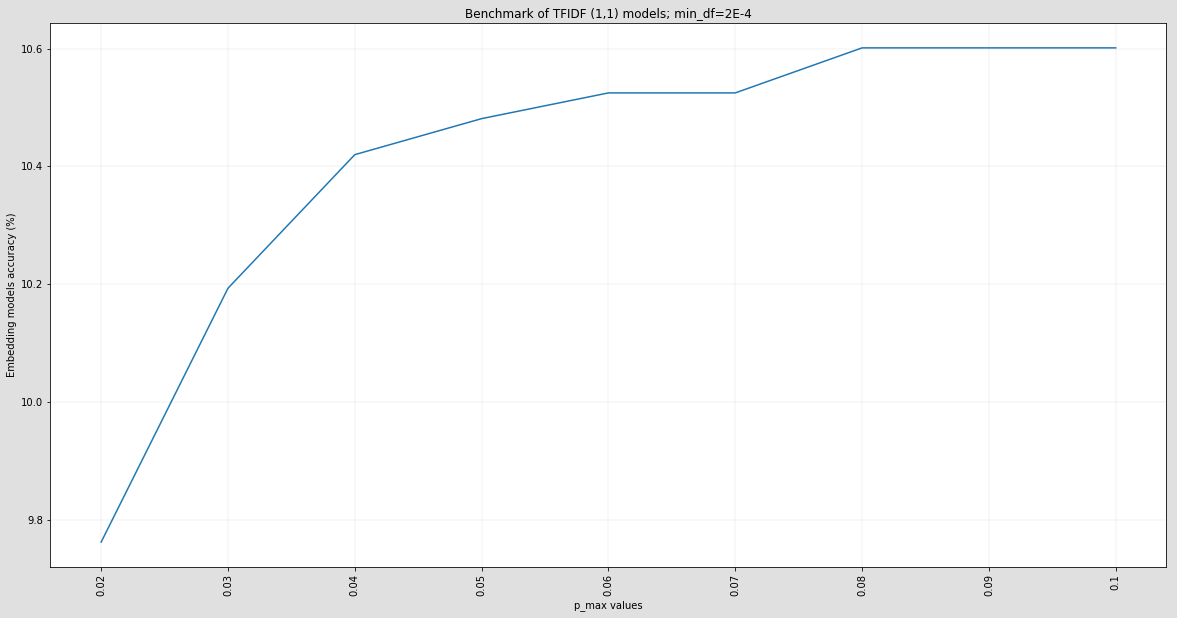

In [36]:
import p6_util_plot
title = "Benchmark of TFIDF (1,1) models; min_df=2E-4"
p6_util_plot.ser_item_occurency_plot(df_result.P_MAX, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=False, p_x_title='p_max values', p_y_title='Embedding models accuracy (%)')

## <font color='blus'> 5.7. Building best TFIDF (1,1) Vectorized model</font>

In [39]:
import p5_util

ngram1=1
ngram2=1
p_min_df=2.E-4
p_max_df=1.0
vectorizer_tfidf_ngram1_b \
= TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))
csr_matrix_tfidf_ngram1_b = vectorizer_tfidf_ngram1_b.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram1_b.shape)
file_name='./data/csr_matrix_tfidf_ngram1_b.dump'
p5_util.object_dump(csr_matrix_tfidf_ngram1_b,file_name)

file_name='./data/vectorizer_tfidf_ngram1_b.dump'
p5_util.object_dump(vectorizer_tfidf_ngram1_b,file_name)



(24604, 6448)


## <font color='blus'> 5.8. Testing best TFIDF (1,1) Vectorization model</font>

In [4]:
import p5_util

file_name='./data/csr_matrix_tfidf_ngram1_b.dump'
csr_matrix_tfidf_ngram1_b = p5_util.object_load(file_name)
print(csr_matrix_tfidf_ngram1_b.shape)

file_name='./data/vectorizer_tfidf_ngram1_b.dump'
vectorizer_tfidf_ngram1_b = p5_util.object_load(file_name)



p5_util.object_load : fileName= ./data/csr_matrix_tfidf_ngram1_b.dump
(24604, 6448)
p5_util.object_load : fileName= ./data/vectorizer_tfidf_ngram1_b.dump


In [44]:

nb_test = int(len(df_sof_test)/10)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))
dict_dict_match_result[0] \
= p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram1_b, csr_matrix_tfidf_ngram1_b,p_tag_ratio=None, embeding_mode='tfidf' )


Nb tests= 1635 Module=163

Test mode tfidf covering 1635 documents

Processed documents : 163/1635
Processed documents : 326/1635
Processed documents : 489/1635
Processed documents : 652/1635
Processed documents : 815/1635
Processed documents : 978/1635
Processed documents : 1141/1635
Processed documents : 1304/1635
Processed documents : 1467/1635
Processed documents : 1630/1635


In [45]:
import p6_util
dict_stat_result_all = dict()
arr_similarity_result, arr_matching_result, stat_mean_accuracy_score \
= p6_util.p6_stat_compute_result(dict_dict_match_result[0])

dict_stat_result_all[0] = stat_mean_accuracy_score



*** Matching results : 0.12 %
